In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import KFold
from scipy import stats

In [76]:
df = pd.read_csv('events_up_to_01062018.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})
labels = pd.read_csv('labels_training_set.csv', low_memory = False).set_index('person')

In [128]:
dfPredictor = pd.DataFrame(df['person'].unique())
dfPredictor.columns = ['person']
dfPredictor = dfPredictor.set_index('person')

#ult60Dias = df.loc[df['timestamp'] > pd.to_datetime('01-04-2018')]
ult30Dias = df.loc[df['timestamp'] > pd.to_datetime('01-05-2018')]
ult15Dias = df.loc[df['timestamp'] > pd.to_datetime('15-05-2018')]
ult5Dias = df.loc[df['timestamp'] > pd.to_datetime('25-05-2018')]
ultDia = df.loc[df['timestamp'] > pd.to_datetime('31-05-2018')]




#
#       Compras o conversiones
#

#checkoutsPorPersonaUlt60Dias = ult60Dias.loc[ult60Dias['event'] == 'checkout']['person'].value_counts().to_frame()
#checkoutsPorPersonaUlt60Dias.columns = ['checkoutsUlt60Dias']
#conversionesPorPersonaUlt60Dias = ult60Dias.loc[ult60Dias['event'] == 'conversion']['person'].value_counts().to_frame()
#conversionesPorPersonaUlt60Dias.columns = ['conversionesUlt60Dias']

checkoutsPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt30Dias.columns = ['checkoutsUlt30Dias']
conversionesPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt30Dias.columns = ['conversionesUlt30Dias']

checkoutsPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt15Dias.columns = ['checkoutsUlt15Dias']
conversionesPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt15Dias.columns = ['conversionesUlt15Dias']

checkoutsPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt5Dias.columns = ['checkoutsUlt5Dias']
conversionesPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt5Dias.columns = ['conversionesUlt5Dias']

checkoutsPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUltDia.columns = ['checkoutsUltDia']
conversionesPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUltDia.columns = ['conversionesUltDia']

#dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt60Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(conversionesPorPersonaUlt60Dias, how = 'left', on = 'person').fillna(value = 0)

dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)

dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)

dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)

dfPredictor = dfPredictor.join(checkoutsPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)

#
#        Canal de origen
#

visitasUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'visited site']
visitasUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'visited site']
visitasUltDia = ultDia.loc[ultDia['event'] == 'visited site']

# Pago

paidUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt15Dias.columns = ['CanalPagoUlt15Dias']

paidUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt5Dias.columns = ['CanalPagoUlt5Dias']

paidUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUltDia.columns = ['CanalPagoUltDia']

#dfPredictor = dfPredictor.join(paidUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(paidUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(paidUltDia, how = 'left', on = 'person').fillna(value = 0)

# Organic

organicUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt15Dias.columns = ['CanalOrganicoUlt15Dias']

organicUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt5Dias.columns = ['CanalOrganicoUlt5Dias']

organicUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUltDia.columns = ['CanalOrganicoUltDia']

#dfPredictor = dfPredictor.join(organicUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(organicUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(organicUltDia, how = 'left', on = 'person').fillna(value = 0)

# Direct

directUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt15Dias.columns = ['CanalDirectoUlt15Dias']

directUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt5Dias.columns = ['CanalDirectoUlt5Dias']

directUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Direct']['person'].value_counts().to_frame()
directUltDia.columns = ['CanalDirectoUltDia']

#dfPredictor = dfPredictor.join(directUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(directUltDia, how = 'left', on = 'person').fillna(value = 0)

# Separo los labels locales
dfPredictorLocal = dfPredictor.join(labels, how = 'inner')

Paid, Organic, Direct, Referral, Social, Email, Unknown

In [129]:
X, y = dfPredictorLocal.iloc[:,:-1], dfPredictorLocal.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [130]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                            colsample_bytree = 0.3, learning_rate = 0.05,
                            max_depth = 4, alpha = 10, n_estimators = 180)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
#preds[preds < 0.009] = 0
roc_auc_score(y_test, preds)

0.84916259063696276

In [131]:
kaggle = pd.read_csv('trocafone_kaggle_test.csv', low_memory = False)
kaggle = kaggle.set_index('person')
dfPredictorSubmit = dfPredictor.join(kaggle, how = 'inner')
predsSubmit = xg_reg.predict(dfPredictorSubmit)
predsSubmit[predsSubmit < 0 ] = 0
predsSubmit[predsSubmit > 1] = 1
dfPredictorSubmit['label'] = predsSubmit
dfPredictorSubmit['label'].to_frame().to_csv('submit.csv')

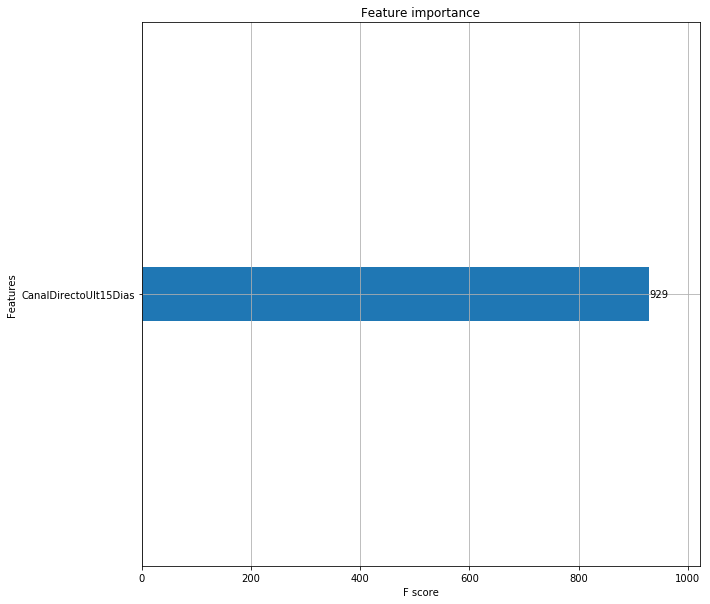

In [349]:

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()